In [54]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

(train_data, val_data, test_data), metadata = tfds.load("rock_paper_scissors", 
                                                        split=['train[:80%]', 'train[80%:90%]', 'train[:90%]'],
                                                        with_info=True)
print(metadata.features)

FeaturesDict({
    'image': Image(shape=(300, 300, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
})


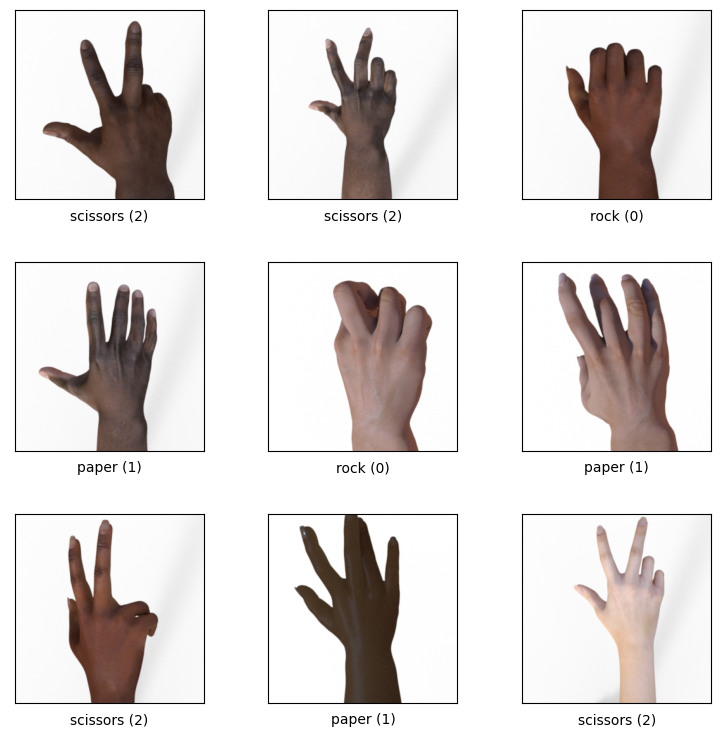

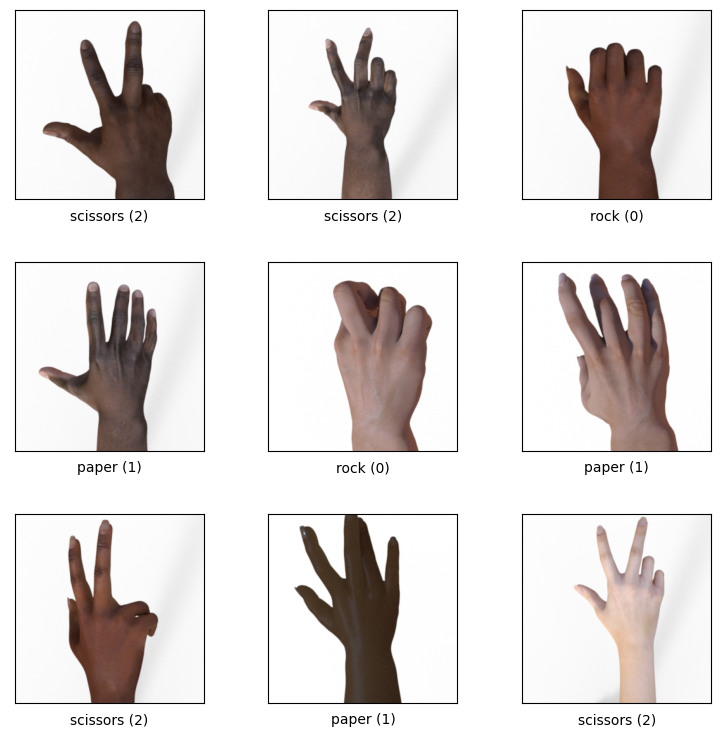

In [55]:
tfds.visualization.show_examples(train_data, metadata)

In [56]:
def preprocess(dataset):
  image = tf.cast(dataset['image'], dtype=tf.float64)
  label = tf.cast(dataset['label'], dtype=tf.float64)

  image = crop_image(image)  
  return image, label

def crop_image(image):
  output = tf.image.central_crop(image, central_fraction = 0.70)
  return output

train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(512)
val_data = val_data.map(preprocess).batch(512)
test_data = test_data.map(preprocess).batch(512)

In [57]:
def simple_mlp_model(num_classes):
  input_ = tf.keras.layers.Input(shape=(210, 210, 3))
  x = tf.keras.layers.Flatten()(input_)
  x = tf.keras.layers.Dense(210, activation='relu')(x)
  output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
  return tf.keras.models.Model(input_, output_, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = simple_mlp_model(num_classes)
model.summary()


Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 210, 210, 3)]     0         
                                                                 
 flatten_7 (Flatten)         (None, 132300)            0         
                                                                 
 dense_19 (Dense)            (None, 210)               27783210  
                                                                 
 dense_20 (Dense)            (None, 3)                 633       
                                                                 
Total params: 27,783,843
Trainable params: 27,783,843
Non-trainable params: 0
_________________________________________________________________


In [58]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0005, 
                                                            decay_steps=100000,
                                                            decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

history = model.fit(train_data, epochs=25,  validation_data = val_data)


Epoch 1/25
4/4 [==============================] - 6s 1s/step - loss: 41287.3828 - accuracy: 0.3199 - val_loss: 34866.2773 - val_accuracy: 0.3492
Epoch 2/25
4/4 [==============================] - 5s 935ms/step - loss: 21993.0781 - accuracy: 0.3408 - val_loss: 5335.8062 - val_accuracy: 0.3611
Epoch 3/25
4/4 [==============================] - 6s 956ms/step - loss: 6946.3721 - accuracy: 0.3438 - val_loss: 6467.6753 - val_accuracy: 0.4048
Epoch 4/25
4/4 [==============================] - 5s 928ms/step - loss: 5227.3486 - accuracy: 0.3814 - val_loss: 1877.1455 - val_accuracy: 0.4484
Epoch 5/25
4/4 [==============================] - 6s 943ms/step - loss: 2639.4109 - accuracy: 0.4246 - val_loss: 4290.3911 - val_accuracy: 0.4008
Epoch 6/25
4/4 [==============================] - 5s 932ms/step - loss: 3459.8354 - accuracy: 0.4415 - val_loss: 1634.7375 - val_accuracy: 0.4603
Epoch 7/25
4/4 [==============================] - 6s 934ms/step - loss: 1729.9038 - accuracy: 0.4663 - val_loss: 2149.5686 -

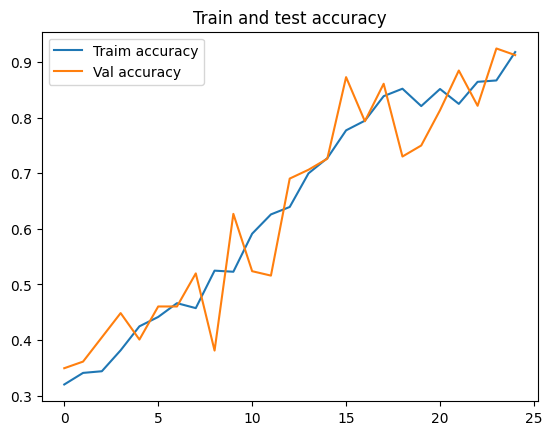

<Figure size 10000x10000 with 0 Axes>

In [59]:
plt.plot(history.history['accuracy'], label= 'Traim accuracy')
plt.plot(history.history['val_accuracy'], label= 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize=(100, 100))
plt.show()

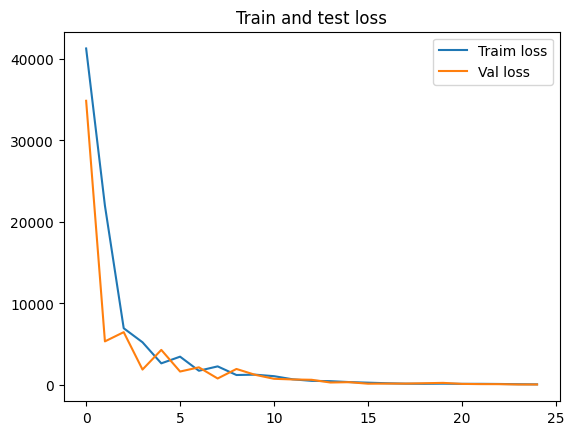

<Figure size 20000x20000 with 0 Axes>

In [60]:
plt.plot(history.history['loss'], label= 'Traim loss')
plt.plot(history.history['val_loss'], label= 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize=(200, 200))
plt.show()